# Chapter 3: Classification

## MNIST

In [1]:
# Downloading the MNIST data.

from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sorted_indices = np.argsort(mnist.target)
mnist.data = mnist.data[sorted_indices]
mnist.target = mnist.target[sorted_indices]
print(mnist)

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8), 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pix

In [2]:
# Examining the downloaded data.

X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


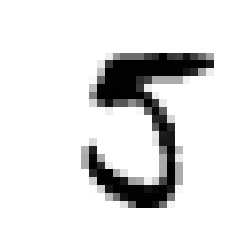

In [3]:
# Plotting an image in the dataset.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
           interpolation='nearest')
plt.axis('off')
plt.show()

In [4]:
# The label should be "9".

print(y[36000])

5


In [5]:
# Split the data into training and test sets.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# Shuffle the training set.

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

In [7]:
# To simplify the problem, let's first train a classifier to see if a handwritten digit is a "5".

y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [8]:
# Starting with the Stochastic Gradient Descent classifier.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict([some_digit]))

[ True]


## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation

In [9]:
# Implementation of a function which is similar to sklearn's cross_val_score().

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.8961103889611038
0.89715
0.8827882788278828


In [10]:
# Using cross_val_score to measure the performance of the SGDClassifier.

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91290435, 0.9644    , 0.87289364])

In [11]:
# The results look promising, however it is because the dataset is not
# balanced, 90% of the samples are false. To illustrate this, we implement
# a classifier which always returns false. This illustrates that accuracy
# is not always the best performance metric.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')

array([0.89605, 0.8949 , 0.8934 ])

### Confusion Matrix

In [12]:
# Uses cross_val_predict to get predictions from cross-validation.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
# Computes the confusion matrix from this cross-validation analysis.
# Confusion matrix:
#  TN FN
#  FP TP

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[49328,  4359],
       [  637,  5676]])

### Precision and Recall

#### Equation for Precision:

$p = \large{\frac{TP}{TP\;+\;FP}}$

which shows how many positive predictions were correct.

#### Equation for Recall:

$r = \large{\frac{TP}{TP\;+\;FN}}$

which shows how what percentage of all positive cases were detected.

In [14]:
# After computing the precision and recall, we see the SGDClassifier is not as good as the
# accuracy metric would lead you to believe.

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.5656203288490284
0.8990971012197053


#### Equation for F1 score:

$ F_1 = \large{\frac{1}{\frac{1}{p} + \frac{1}{r}}} = \small{2\;\times\;}\large{\frac{p\;\times\;r}{p\;+\;r}}
= \large{\frac{TP}{TP\;+\;\frac{FN\;+\;FP}{2}}} $

$F_1$ score is the harmonic mean of the precision and recall. If one of the values are low, the mean will favor
that low value.

In [15]:
# Scikit-Learn provides a utility function for computing F1 score.

from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.6943968681184242


### Precision/Recall Tradeoff

In [16]:
# There is generally a tradeoff between precision and recall. You can
# increase precision by increasing the threshold needed to classify a
# sample as positive, but this hurts recall. Conversely you could make
# the threshold more lax, increasing recall but hurting precision.

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[5659.25818803]
[ True]
[False]


In [17]:
# Now we have cross_val_predict return the decision scores instead of predictions.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [18]:
# Now it is possible to compute precision and recall for all possible threshold values
# using Scikit-Learn's precision_recall_curve().

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

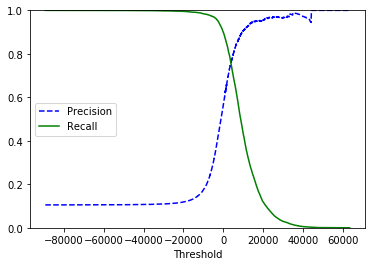

In [19]:
# Plots the precision and recall as functions of the threshold.

def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

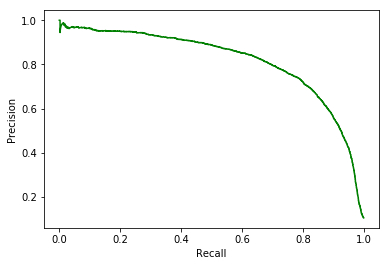

In [20]:
# You can also plot precision as a function of recall to gain insights.

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'g-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

The _receiver operating characteristic_ (ROC) curve is a plot of the true positive rate (TPR or recall)
as a function of the false positive rate (FPR)

#### Equation for FPR:

$ FPR \; = \large{\frac{FP}{TN\;+\;FP}} $

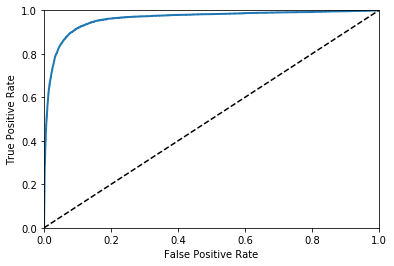

In [21]:
# Plotting the ROC curve using Scikit-Learn. The dotted line represents a purely
# random classifier.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
# One way to measure the performance of a classifier is to compute the area under curve (AUC)
# of the ROC function. A random classifier would have an AUC of 0.5 and a perfect classifier
# would have an AUC of 1.

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9610136496125314

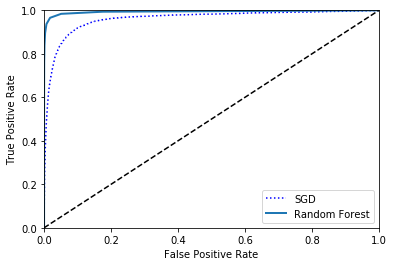

In [23]:
# Training a RandomForestClassifier and compare its ROC AUC score to the
# SGDClassifier.

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method='predict_proba')

y_scores_forest = y_probas_forest[:, -1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Also display the ROC AUC score of the RandomForestClassifier.

roc_auc_score(y_train_5, y_scores_forest)

0.9938371464303372